In [4]:
from fastkaggle import *
from pathlib import Path

While not particularly relevant when running on appropriately powered AWS machines such as what i have used in this course, Jeremy suggests considering how to make the code more efficient on the Kaggle GPUs. Decoding and resizing large images is CPU-bound, so we can resize all the images off the bat to get some better performance. We are going to resize the images to half their width and height, so that should give a 4x improvement in performance.

## Speeding things up

In [13]:
comp = "paddy-disease-classification"
path = Path(".") / Path(comp)
from fastai.vision.all import *
set_seed(42)

In [14]:
trn_path = Path("sml")

In [15]:
resize_images(path / "train_images", dest = trn_path, max_size=256, recurse=True)

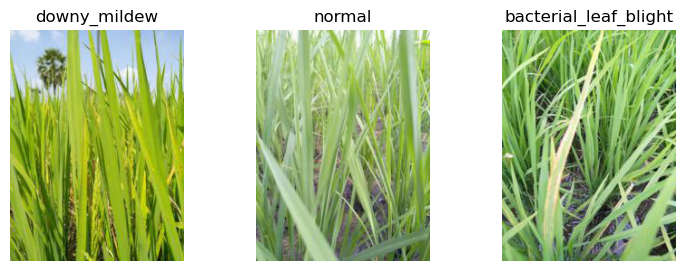

In [16]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

Now we have smaller images. We are going to experiment with a few different architectures and image processing technqiues, so we put all of that into a function to make it reusable.

In [27]:
def train(arch, item, batch, epochs=5):
    dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [18]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.906319,1.529405,0.491110,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.268558,1.025072,0.337818,00:16
1,1.004738,0.719127,0.237866,00:16
2,0.683639,0.506167,0.165786,00:16
3,0.506193,0.400640,0.125420,00:16
4,0.432729,0.387321,0.124940,00:16


In the previous notebook, we already used resize transforms so our accuracy remains about the same. The speed is much better though.

## ConvNeXt model

Let's see if we can use a more capable model that tests the GPU a bit. `convnext_small` models give the best price to performance, so lets try one of them.

In [19]:
arch = "convnext_small_in22k"

In [20]:
learn = train(arch, item=Resize(192, method="squish"),
              batch=aug_transforms(size=128, min_scale=0.75))

/home/ubuntu/miniconda3/envs/fastai/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.295004,0.829270,0.276309,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.643393,0.490696,0.156655,00:30
1,0.510974,0.354064,0.111004,00:30
2,0.304321,0.244320,0.077367,00:30
3,0.198919,0.166136,0.049976,00:30
4,0.130865,0.150546,0.044210,00:30


The convnext model provides a significant improvement! Let's iterate on this model.

### Preprocessing Experiments

The way that image sizes are handled also impacts performance. In the previous example, we used squishing to resize the images. As expected, this can result in information loss across the longer direction as there are less pixel to represent the same amount of information. Instead, let's try using the default method, which is to crop in.

In [23]:
learn = train(arch, item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.310891,0.954860,0.270062,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.718110,0.551285,0.186929,00:29
1,0.579836,0.387972,0.118212,00:29
2,0.354961,0.261792,0.079289,00:30
3,0.240086,0.198780,0.059106,00:30
4,0.165776,0.172361,0.049976,00:30


Not a significant change.

We can also try padding. You can pad in various ways, like reflecting the image, continuing the border pixels, and simply placing zeros. Zeros are favourable as they contain no information, so the model should not be impacted by those pixels.

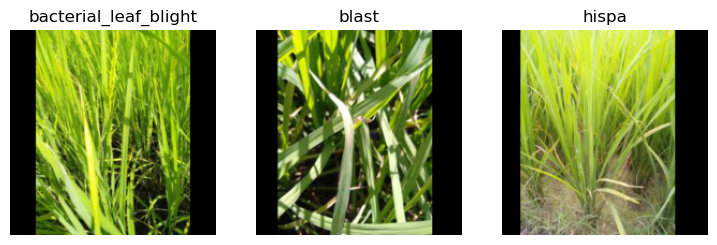

In [24]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls.show_batch(max_n=3)

In [28]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.292251,0.804139,0.257568,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.655445,0.478263,0.159539,00:34
1,0.515667,0.328396,0.102835,00:34
2,0.339849,0.223597,0.066795,00:34
3,0.196857,0.182017,0.056704,00:34
4,0.145023,0.172565,0.052859,00:34


## Test Time Augmentation

To make the predictions even better, we can try [test time augmentation](https://nbviewer.org/github/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb#Test-Time-Augmentation) (TTA), which [our book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) defines as:

> *During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.*

Before trying that out, we'll first see how to check the predictions and error rate of our model without TTA:

In [29]:
valid = learn.dls.valid

In [30]:
preds, targs = learn.get_preds(dl=valid)
error_rate(preds, targs)

TensorBase(0.0529)

This should be the same as what we got at the end of training above, so let's take a look at what the TTA data augmentation does. If we look at the batch we can see that the images are warped, flipped, zoomed, rotated or a bit lighter or darker.

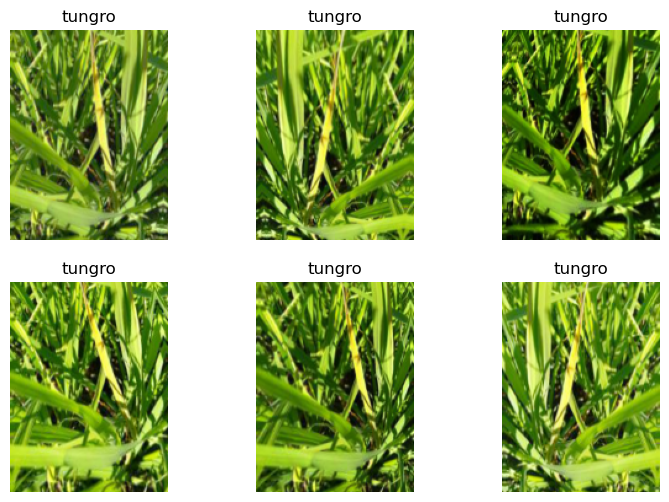

In [31]:
learn.dls.train.show_batch(max_n=6, unique=True)

To use TTA in fastai we call `learn.tta()`.

In [32]:
tta_preds, _ = learn.tta(dl=valid)

In [33]:
error_rate(tta_preds, targs)

TensorBase(0.0404)

Much better in comparison!

## Scaling Up

Let's now do all of this on the full size images and train for more epochs. We'll use our best settings so far, and use 12 epochs.

In [34]:
trn_path = path / "train_images"

In [35]:
learn = train(arch, epochs=12,
              item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
              batch=aug_transforms(size=(256,192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.084566,0.642024,0.216242,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.481956,0.292871,0.094666,01:16
1,0.388334,0.273746,0.086977,01:16
2,0.367243,0.285697,0.086977,01:16
3,0.273022,0.238411,0.066795,01:17
4,0.220969,0.228197,0.060548,01:17
5,0.173437,0.196473,0.052379,01:17
6,0.168523,0.141005,0.033638,01:17
7,0.103581,0.108638,0.025949,01:17
8,0.069699,0.115106,0.027871,01:17
9,0.056542,0.093962,0.020663,01:17


Of course, we use TTA here as well.

In [36]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

TensorBase(0.0187)

## Let's Submit to Kaggle

In [39]:
tst_files = get_image_files(path/"test_images").sorted()
tst_dl = learn.dls.test_dl(tst_files)

We start by predicting with test time augmentation:

In [40]:
preds, _ = learn.tta(dl=tst_dl)

We now need the most probable prediction in each row, or its index.

In [41]:
idxs = preds.argmax(dim=1)

We now look these up in vocab, and map the index to a label.

In [42]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [43]:
ss = pd.read_csv(path/"sample_submission.csv")
ss["label"] = results
ss.to_csv("subm.csv", index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [44]:
from kaggle import api
api.competition_submit_cli('subm.csv', 'convnext small 256x192 12 epochs tta', comp)

100%|██████████████████████████████████████| 70.5k/70.5k [00:01<00:00, 71.7kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification